##### Import Modules

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

##### Load and Transform Data

In [ ]:
# transforms
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
# load mnist
data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_len = len(data)
train_len = int(data_len * 0.8)
val_len = data_len - train_len

train, val = torch.utils.data.random_split(data, [train_len, val_len])

test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train, batch_size=64, shuffle=True)
val_loader = DataLoader(val, batch_size=64, shuffle=False)
test_loader = DataLoader(test, batch_size=64, shuffle=False)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 490kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.55MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.22MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



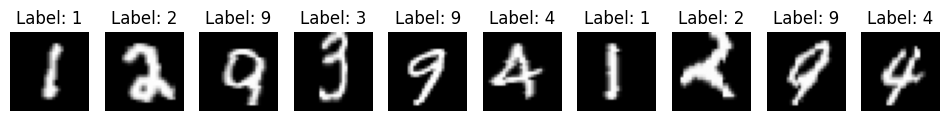

In [ ]:
# data visualisation
examples = iter(train_loader)
example_data, example_labels = next(examples)

plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(example_data[i][0], cmap="gray")
    plt.title(f"Label: {example_labels[i].item()}")
    plt.axis("off")
plt.show()

##### MLP Model

BatchNorm1d normalises the inputs such that they have a mean of 0 and standard deviation 1. This is done to stabilise the learning process (mitigating internal covariate shift) which leads to faster training, improved generalisation.

Dropout randomly sets a fraction of the neurons to zero during training. This is done to prevent overfitting

In [ ]:
# MLP model
class MLP(nn.Module):
    def __init__(self, input_size=28*28, hidden_sizes=[256,128]):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.BatchNorm1d(hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.BatchNorm1d(hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden_sizes[1], 10)
        )

    def forward(self, x):
        return self.model(x)

Kaiming Uniform initialisation is used where weights are sampled from a uniform distribution. ReLU activation functions output zero for negative inputs, effectively deactivating certain neurons. Kaiming ensures that the variance of the activations remains consistent across layers, even if some neurons are inactive.


In [ ]:
# weight initialisation
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [ ]:
# initialise model, optimisr and loss func
model = MLP()
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# get device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MLP(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=10, bias=True)
  )
)

##### Training, Validation and Testing Function

In [ ]:
# training loop
train_losses = []
val_losses = []
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            # load data to device
            images, labels = images.to(device), labels.to(device)

            # flatten image to 1d
            images = images.view(images.size(0), -1)

            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels) #compute loss

            # backpropagation
            optimizer.zero_grad() #clear gradients
            loss.backward() #compute gradients of loss wrt params
            optimizer.step() #update model params

            running_loss += loss.item()

        train_losses.append(running_loss/len(train_loader))

        # validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                images = images.view(images.size(0), -1)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_losses.append(val_loss/len(val_loader))

        print(f"Epoch[{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")

In [ ]:
def test_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # flatten image to 1d
            images = images.view(images.size(0), -1)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

##### Implementation

In [ ]:
# train model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)
torch.save(model.state_dict(), "mnist_mlp.pth")
print("Model saved")

Epoch[1/10], Train Loss: 0.6056, Validation Loss: 0.2555
Epoch[2/10], Train Loss: 0.3327, Validation Loss: 0.1805
Epoch[3/10], Train Loss: 0.2761, Validation Loss: 0.1519
Epoch[4/10], Train Loss: 0.2456, Validation Loss: 0.1369
Epoch[5/10], Train Loss: 0.2214, Validation Loss: 0.1211
Epoch[6/10], Train Loss: 0.2067, Validation Loss: 0.1179
Epoch[7/10], Train Loss: 0.1960, Validation Loss: 0.1022
Epoch[8/10], Train Loss: 0.1848, Validation Loss: 0.1022
Epoch[9/10], Train Loss: 0.1776, Validation Loss: 0.0965
Epoch[10/10], Train Loss: 0.1737, Validation Loss: 0.0847
Model saved


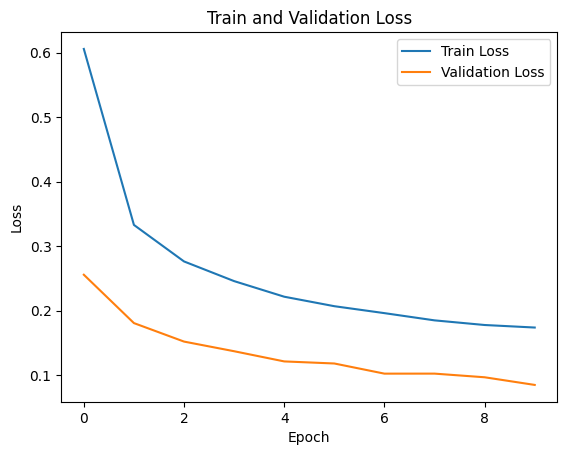

In [ ]:
# Plot train and validation loss
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Train and Validation Loss")
plt.show()

The validation loss is lower than the training loss. This is due to regularisation that is applied during training (to avoid overfitting and generalise). Regularization methods often sacrifice training accuracy to improve validation/testing accuracy, hence the results.

##### Evaluating Model Performance

In [ ]:
# test model
labels, preds = test_model(model, test_loader)

In [ ]:
# accuracy
acc = accuracy_score(labels, preds)
print(f"Test Accuracy: {100 * acc:.2f}%")

Test Accuracy: 97.33%


In [ ]:
# precision, recall and f1 score
precision = precision_score(labels, preds, average='weighted')
recall = recall_score(labels, preds, average='weighted')
f1 = f1_score(labels, preds, average='weighted')
print("Precision:", precision)
print("Recall", recall)
print("F1 score", f1)

Precision: 0.9733639417981096
Recall 0.9733
F1 score 0.9732777464782852


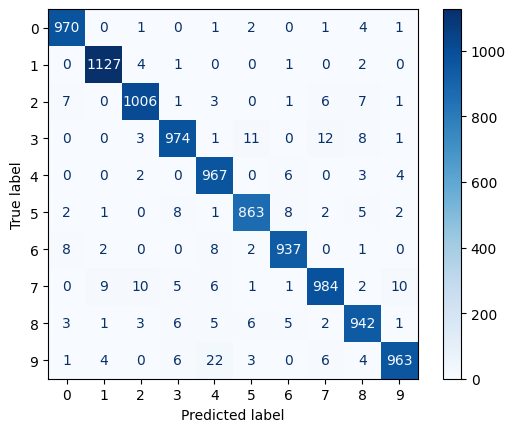

In [ ]:
# confusion matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap="Blues")
plt.show()

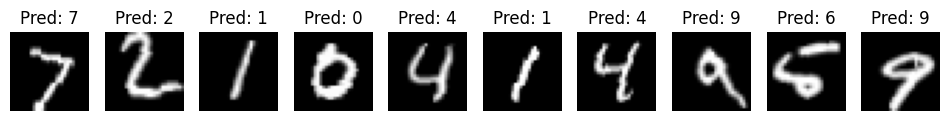

In [ ]:
# image and preidicted labels examples
sample_images, sample_labels = next(iter(test_loader))
sample_images = sample_images[:10].to(device)
sample_preds = torch.tensor(preds).to(device)
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(sample_images[i].view(28, 28).cpu().numpy(), cmap="gray")
    plt.title(f"Pred: {sample_preds[i].item()}")
    plt.axis("off")
plt.show()

##### Regularization Analysis

In [ ]:
def analyze_regularization():
    print("Analyzing the impact of custom regularization on overfitting...")

    # retrain the model without Dropout layers
    model_no_dropout = MLP()
    model_no_dropout.model[3] = nn.Identity()
    model_no_dropout.model[7] = nn.Identity()
    model_no_dropout.apply(init_weights)
    model_no_dropout.to(device)

    optimizer_no_dropout = optim.Adam(model_no_dropout.parameters(), lr=0.001)
    train_losses_no_dropout = []
    val_losses_no_dropout = []

    # training and validation
    for epoch in range(10):
        model_no_dropout.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            images = images.view(images.size(0), -1)
            outputs = model_no_dropout(images)
            loss = criterion(outputs, labels)
            optimizer_no_dropout.zero_grad()
            loss.backward()
            optimizer_no_dropout.step()
            running_loss += loss.item()
        train_losses_no_dropout.append(running_loss / len(train_loader))

        model_no_dropout.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                images = images.view(images.size(0), -1)
                outputs = model_no_dropout(images)
                val_loss += criterion(outputs, labels).item()
        val_losses_no_dropout.append(val_loss / len(val_loader))

    # compare with and without droput loss
    plt.plot(train_losses, label="Train Loss (with Dropout)")
    plt.plot(val_losses, label="Validation Loss (with Dropout)")
    plt.plot(train_losses_no_dropout, label="Train Loss (no Dropout)", linestyle='--')
    plt.plot(val_losses_no_dropout, label="Validation Loss (no Dropout)", linestyle='--')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Impact of Regularization on Overfitting")
    plt.show()

Analyzing the impact of custom regularization on overfitting...


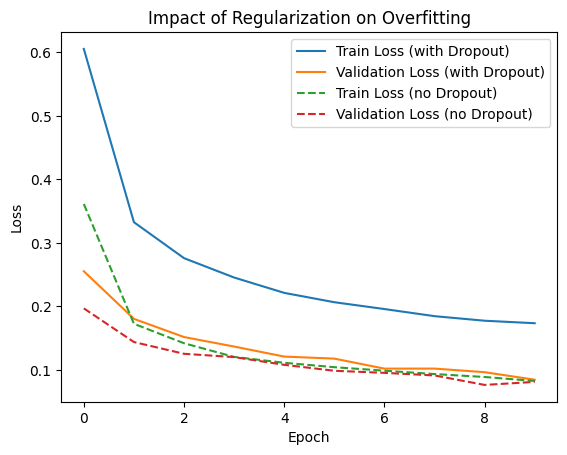

In [ ]:
analyze_regularization()

Training loss with dropout is consistently higher than training loss with no dropout. This is as expected as dropout prevents the model from memorizing the data and discourages overfitting

##### Hyperparameter Tuning

Number of neurons and learning rate have a significant impact training efficiency and hence tuning these paramters is key to have the most optimal learning strategy for the model

In [ ]:
def hyperparameter_tuning():
    hidden_layer_configs = [[256, 128], [512, 256], [128, 64]]
    learning_rates = [0.001, 0.0005, 0.0001]
    best_config = None
    best_val_loss = float('inf')

    for hidden_sizes in hidden_layer_configs:
        for lr in learning_rates:
            model = MLP(hidden_sizes=hidden_sizes)
            model.apply(init_weights)
            model.to(device)

            optimizer = optim.Adam(model.parameters(), lr=lr)

            print("Training with hidden sizes ", hidden_sizes, "and learning rate ", lr)
            train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)

            val_loss = val_losses[-1]
            print("Validation loss: ", val_loss)
            print("----------------------------------------------------------------")

            if val_losses[-1] < best_val_loss:
                best_val_loss = val_losses[-1]
                best_config = (hidden_sizes, lr)


    print()
    print("Best config:")
    print("-> Hidden Sizes: ", best_config[0])
    print("-> Learning Rate: ", best_config[1])
    print("-> with Validation Loss", best_val_loss)

In [ ]:
hyperparameter_tuning()

Training with hidden sizes  [256, 128] and learning rate  0.001
Epoch[1/5], Train Loss: 0.5987, Validation Loss: 0.2396
Epoch[2/5], Train Loss: 0.3305, Validation Loss: 0.1752
Epoch[3/5], Train Loss: 0.2763, Validation Loss: 0.1474
Epoch[4/5], Train Loss: 0.2429, Validation Loss: 0.1308
Epoch[5/5], Train Loss: 0.2211, Validation Loss: 0.1224
Validation loss:  0.12244843317076881
----------------------------------------------------------------
Training with hidden sizes  [256, 128] and learning rate  0.0005
Epoch[1/5], Train Loss: 0.7360, Validation Loss: 0.3191
Epoch[2/5], Train Loss: 0.4074, Validation Loss: 0.2136
Epoch[3/5], Train Loss: 0.3223, Validation Loss: 0.1760
Epoch[4/5], Train Loss: 0.2811, Validation Loss: 0.1519
Epoch[5/5], Train Loss: 0.2484, Validation Loss: 0.1406
Validation loss:  0.14063995085815165
----------------------------------------------------------------
Training with hidden sizes  [256, 128] and learning rate  0.0001
Epoch[1/5], Train Loss: 1.2639, Validati